Notebook written by [Zhedong Zheng](https://github.com/zhedongzheng)

![title](dcgan.png)

In [1]:
%matplotlib inline
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DCGAN:
    def __init__(self, G_size, img_size, img_ch, shape_trace, kernel_size=(5, 5), strides=(2, 2)):
        self.G_size = G_size
        self.img_size = img_size
        self.img_ch = img_ch
        self.shape_trace = shape_trace
        self.kernel_size = kernel_size
        self.strides = strides
        self.build_graph()


    def build_graph(self):
        self.add_input_layer()
        with tf.variable_scope('G'):
            self.G_out = self.generate(self.G_in)
        with tf.variable_scope('D'):
            self.G_logits = self.discriminate(self.G_out)
            self.X_logits = self.discriminate(self.X_in, reuse=True)
            self.G_prob = tf.sigmoid(self.G_logits)
            self.X_prob = tf.sigmoid(self.X_logits)
        self.add_backward_path()


    def add_input_layer(self):
        self.G_in = tf.placeholder(tf.float32, [None, self.G_size])
        self.X_in = tf.placeholder(tf.float32, [None, self.img_size[0],
                                                      self.img_size[1],
                                                      self.img_ch])
        self.train_flag = tf.placeholder(tf.bool)


    def add_backward_path(self):
        ones = tf.ones_like(self.G_logits)
        zeros = tf.zeros_like(self.G_logits)

        self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=ones,
                                                                             logits=self.G_logits))
        D_loss_X = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=ones,
                                                                          logits=self.X_logits))
        D_loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=zeros,
                                                                          logits=self.G_logits))
        self.D_loss = D_loss_X + D_loss_G

        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='G')):
            self.G_train = tf.train.AdamOptimizer(2e-4, beta1=0.5).minimize(
                self.G_loss, var_list=tf.trainable_variables('G'))

        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='D')):
            self.D_train = tf.train.AdamOptimizer(2e-4, beta1=0.5).minimize(
                self.D_loss, var_list=tf.trainable_variables('D'))

        self.mse = tf.reduce_mean(tf.squared_difference(self.G_out, self.X_in))


    def generate(self, x):
        # for example: 100 -> (7, 7, 128) ->  (14, 14, 64) -> (28, 28, 1)
        x = tf.layers.dense(x, np.prod(self.shape_trace[0]), tf.nn.leaky_relu)
        x = tf.reshape(x, [-1, self.shape_trace[0][0],
                               self.shape_trace[0][1],
                               self.shape_trace[0][2]])
        for s in self.shape_trace[1:]:
            x = tf.layers.conv2d_transpose(x,
                                           s[-1],
                                           self.kernel_size,
                                           strides=self.strides,
                                           padding='same')
            x = tf.layers.batch_normalization(x,
                                              training=self.train_flag,
                                              momentum=0.9)
            x = tf.nn.leaky_relu(x)
        x = tf.layers.conv2d_transpose(x,
                                       self.img_ch,
                                       self.kernel_size,
                                       strides=self.strides,
                                       padding='same')
        return tf.tanh(x)


    def discriminate(self, x, reuse=False):
        # for example: (28, 28, 1) -> (14, 14, 64) -> (7, 7, 128) -> 1
        for i, s in enumerate(list(reversed(self.shape_trace))):
            x = tf.layers.conv2d(x,
                                 s[-1],
                                 self.kernel_size,
                                 strides=self.strides,
                                 padding='same',
                                 name='cnn%d'%i,
                                 reuse=reuse)
            x = tf.layers.batch_normalization(x,
                                              training=self.train_flag,
                                              name='bn%d'%i, reuse=reuse,
                                              momentum=0.9)
            x = tf.nn.leaky_relu(x)
        x = tf.layers.dense(tf.layers.flatten(x), 1, name='output', reuse=reuse)
        return x

In [3]:
def gen_batch(arr, batch_size):
    for i in range(0, len(arr), batch_size):
        yield arr[i : i+batch_size]


def tanh_scaled(images):
    return (images.astype(np.float32) - (255./2)) / (255./2)


def select(images, labels, num):
    return np.expand_dims(images, 3)[labels == num]


def experiment(N_EPOCH, BATCH_SIZE, G_SIZE, DIGIT):    
    (X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
    X = select(tanh_scaled(X_train), y_train, DIGIT)
    
    gan = DCGAN(G_SIZE, (28, 28), 1, shape_trace=[(7, 7, 128),
                                                  (14, 14, 64)])
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    for i, epoch in enumerate(range(N_EPOCH)):
        X = shuffle(X)
        for step, images in enumerate(gen_batch(X, BATCH_SIZE)):
            noise = np.random.randn(images.shape[0], G_SIZE)

            sess.run(gan.D_train, {gan.G_in: noise,
                                   gan.X_in: images,
                                   gan.train_flag: True})
            for _ in range(2):
                sess.run(gan.G_train, {gan.G_in: noise,
                                       gan.train_flag: True})

            G_loss, D_loss, D_prob, G_prob, mse = sess.run([gan.G_loss,
                                                            gan.D_loss,
                                                            gan.X_prob,
                                                            gan.G_prob,
                                                            gan.mse],
                                                           {gan.G_in: noise,
                                                            gan.X_in: images,
                                                            gan.train_flag: False})
            
            print("Epoch %d/%d | Step %d/%d" % (epoch+1, N_EPOCH, step, len(X)//BATCH_SIZE))
            print("G loss: %.4f | D loss: %.4f | D prob: %.4f | G prob: %.4f | mse: %.4f" %
                 (G_loss, D_loss, D_prob.mean(), G_prob.mean(), mse))
    
    img = sess.run(gan.G_out, {gan.G_in: noise, gan.train_flag: False})[0]
    plt.imshow(np.squeeze(img))

Epoch 1/20 | Step 0/45
G loss: 0.7103 | D loss: 1.3192 | D prob: 0.5260 | G prob: 0.4915 | mse: 0.9098
Epoch 1/20 | Step 1/45
G loss: 0.7372 | D loss: 1.2812 | D prob: 0.5328 | G prob: 0.4784 | mse: 0.9096
Epoch 1/20 | Step 2/45
G loss: 0.7800 | D loss: 1.2671 | D prob: 0.5207 | G prob: 0.4584 | mse: 0.9132
Epoch 1/20 | Step 3/45
G loss: 0.8430 | D loss: 1.2484 | D prob: 0.5050 | G prob: 0.4304 | mse: 0.9130
Epoch 1/20 | Step 4/45
G loss: 0.9305 | D loss: 1.2209 | D prob: 0.4886 | G prob: 0.3944 | mse: 0.9146
Epoch 1/20 | Step 5/45
G loss: 1.0401 | D loss: 1.2167 | D prob: 0.4606 | G prob: 0.3534 | mse: 0.9136
Epoch 1/20 | Step 6/45
G loss: 1.1521 | D loss: 1.1994 | D prob: 0.4441 | G prob: 0.3160 | mse: 0.9103
Epoch 1/20 | Step 7/45
G loss: 1.2480 | D loss: 1.1912 | D prob: 0.4305 | G prob: 0.2871 | mse: 0.9051
Epoch 1/20 | Step 8/45
G loss: 1.3365 | D loss: 1.1850 | D prob: 0.4217 | G prob: 0.2628 | mse: 0.9018
Epoch 1/20 | Step 9/45
G loss: 1.4146 | D loss: 1.1876 | D prob: 0.4128 |

Epoch 2/20 | Step 33/45
G loss: 0.5204 | D loss: 1.5488 | D prob: 0.5761 | G prob: 0.5998 | mse: 0.3986
Epoch 2/20 | Step 34/45
G loss: 0.9862 | D loss: 1.8354 | D prob: 0.2968 | G prob: 0.3839 | mse: 0.4191
Epoch 2/20 | Step 35/45
G loss: 0.6337 | D loss: 1.6635 | D prob: 0.4554 | G prob: 0.5406 | mse: 0.4107
Epoch 2/20 | Step 36/45
G loss: 0.8867 | D loss: 1.7903 | D prob: 0.3319 | G prob: 0.4229 | mse: 0.4070
Epoch 2/20 | Step 37/45
G loss: 0.5966 | D loss: 1.5752 | D prob: 0.5146 | G prob: 0.5575 | mse: 0.4023
Epoch 2/20 | Step 38/45
G loss: 1.1137 | D loss: 1.9487 | D prob: 0.2441 | G prob: 0.3389 | mse: 0.4111
Epoch 2/20 | Step 39/45
G loss: 0.5062 | D loss: 1.4446 | D prob: 0.6424 | G prob: 0.6105 | mse: 0.4070
Epoch 2/20 | Step 40/45
G loss: 1.2169 | D loss: 1.8622 | D prob: 0.2546 | G prob: 0.3099 | mse: 0.4258
Epoch 2/20 | Step 41/45
G loss: 0.4926 | D loss: 1.4888 | D prob: 0.6313 | G prob: 0.6183 | mse: 0.4020
Epoch 2/20 | Step 42/45
G loss: 1.3398 | D loss: 2.1553 | D prob

Epoch 4/20 | Step 20/45
G loss: 0.5299 | D loss: 1.3961 | D prob: 0.6359 | G prob: 0.5946 | mse: 0.4389
Epoch 4/20 | Step 21/45
G loss: 0.8489 | D loss: 1.4094 | D prob: 0.4511 | G prob: 0.4351 | mse: 0.4238
Epoch 4/20 | Step 22/45
G loss: 0.8570 | D loss: 1.4374 | D prob: 0.4434 | G prob: 0.4348 | mse: 0.4456
Epoch 4/20 | Step 23/45
G loss: 0.6236 | D loss: 1.4542 | D prob: 0.5308 | G prob: 0.5425 | mse: 0.4464
Epoch 4/20 | Step 24/45
G loss: 0.9987 | D loss: 1.5042 | D prob: 0.3755 | G prob: 0.3785 | mse: 0.4144
Epoch 4/20 | Step 25/45
G loss: 0.5348 | D loss: 1.4249 | D prob: 0.6160 | G prob: 0.5924 | mse: 0.4484
Epoch 4/20 | Step 26/45
G loss: 1.0571 | D loss: 1.5384 | D prob: 0.3481 | G prob: 0.3539 | mse: 0.4426
Epoch 4/20 | Step 27/45
G loss: 0.5084 | D loss: 1.3895 | D prob: 0.6566 | G prob: 0.6075 | mse: 0.4272
Epoch 4/20 | Step 28/45
G loss: 1.0859 | D loss: 1.5348 | D prob: 0.3429 | G prob: 0.3453 | mse: 0.4280
Epoch 4/20 | Step 29/45
G loss: 0.5258 | D loss: 1.3995 | D prob

Epoch 6/20 | Step 7/45
G loss: 0.5206 | D loss: 1.3796 | D prob: 0.6625 | G prob: 0.6018 | mse: 0.4503
Epoch 6/20 | Step 8/45
G loss: 1.0237 | D loss: 1.3759 | D prob: 0.4246 | G prob: 0.3718 | mse: 0.4475
Epoch 6/20 | Step 9/45
G loss: 0.6629 | D loss: 1.2885 | D prob: 0.6025 | G prob: 0.5243 | mse: 0.4788
Epoch 6/20 | Step 10/45
G loss: 0.9486 | D loss: 1.2944 | D prob: 0.4729 | G prob: 0.3981 | mse: 0.4478
Epoch 6/20 | Step 11/45
G loss: 0.6663 | D loss: 1.2699 | D prob: 0.6084 | G prob: 0.5215 | mse: 0.4427
Epoch 6/20 | Step 12/45
G loss: 1.1084 | D loss: 1.3903 | D prob: 0.3967 | G prob: 0.3398 | mse: 0.4485
Epoch 6/20 | Step 13/45
G loss: 0.5055 | D loss: 1.3486 | D prob: 0.6877 | G prob: 0.6092 | mse: 0.4398
Epoch 6/20 | Step 14/45
G loss: 1.4226 | D loss: 1.4803 | D prob: 0.3271 | G prob: 0.2517 | mse: 0.4631
Epoch 6/20 | Step 15/45
G loss: 0.4393 | D loss: 1.3940 | D prob: 0.7499 | G prob: 0.6523 | mse: 0.4553
Epoch 6/20 | Step 16/45
G loss: 1.2557 | D loss: 1.4035 | D prob: 0

Epoch 7/20 | Step 40/45
G loss: 0.6914 | D loss: 1.2199 | D prob: 0.6179 | G prob: 0.5081 | mse: 0.4579
Epoch 7/20 | Step 41/45
G loss: 1.1299 | D loss: 1.3403 | D prob: 0.4136 | G prob: 0.3348 | mse: 0.4386
Epoch 7/20 | Step 42/45
G loss: 0.5809 | D loss: 1.2596 | D prob: 0.6725 | G prob: 0.5653 | mse: 0.4495
Epoch 7/20 | Step 43/45
G loss: 1.2790 | D loss: 1.3431 | D prob: 0.3891 | G prob: 0.2881 | mse: 0.4537
Epoch 7/20 | Step 44/45
G loss: 0.5209 | D loss: 1.3268 | D prob: 0.6910 | G prob: 0.6002 | mse: 0.4659
Epoch 7/20 | Step 45/45
G loss: 1.2325 | D loss: 1.4197 | D prob: 0.3717 | G prob: 0.3035 | mse: 0.4713
Epoch 8/20 | Step 0/45
G loss: 0.5603 | D loss: 1.2955 | D prob: 0.6774 | G prob: 0.5793 | mse: 0.4684
Epoch 8/20 | Step 1/45
G loss: 1.0136 | D loss: 1.2836 | D prob: 0.4652 | G prob: 0.3777 | mse: 0.4572
Epoch 8/20 | Step 2/45
G loss: 0.6421 | D loss: 1.2574 | D prob: 0.6274 | G prob: 0.5333 | mse: 0.4451
Epoch 8/20 | Step 3/45
G loss: 0.9700 | D loss: 1.2896 | D prob: 0.

Epoch 9/20 | Step 27/45
G loss: 0.3143 | D loss: 1.5560 | D prob: 0.8164 | G prob: 0.7333 | mse: 0.4462
Epoch 9/20 | Step 28/45
G loss: 1.6392 | D loss: 1.5598 | D prob: 0.2808 | G prob: 0.2062 | mse: 0.4688
Epoch 9/20 | Step 29/45
G loss: 0.3905 | D loss: 1.4555 | D prob: 0.8020 | G prob: 0.6864 | mse: 0.4491
Epoch 9/20 | Step 30/45
G loss: 1.1769 | D loss: 1.3668 | D prob: 0.4015 | G prob: 0.3263 | mse: 0.4599
Epoch 9/20 | Step 31/45
G loss: 0.6462 | D loss: 1.2248 | D prob: 0.6571 | G prob: 0.5342 | mse: 0.4694
Epoch 9/20 | Step 32/45
G loss: 0.8974 | D loss: 1.2106 | D prob: 0.5324 | G prob: 0.4186 | mse: 0.4462
Epoch 9/20 | Step 33/45
G loss: 0.8128 | D loss: 1.2144 | D prob: 0.5671 | G prob: 0.4539 | mse: 0.4677
Epoch 9/20 | Step 34/45
G loss: 0.7978 | D loss: 1.2606 | D prob: 0.5559 | G prob: 0.4643 | mse: 0.4671
Epoch 9/20 | Step 35/45
G loss: 0.7690 | D loss: 1.2330 | D prob: 0.5713 | G prob: 0.4730 | mse: 0.4531
Epoch 9/20 | Step 36/45
G loss: 0.8719 | D loss: 1.2694 | D prob

Epoch 11/20 | Step 14/45
G loss: 0.7634 | D loss: 1.2095 | D prob: 0.5902 | G prob: 0.4745 | mse: 0.4514
Epoch 11/20 | Step 15/45
G loss: 0.8817 | D loss: 1.2492 | D prob: 0.5228 | G prob: 0.4253 | mse: 0.4692
Epoch 11/20 | Step 16/45
G loss: 0.8666 | D loss: 1.2233 | D prob: 0.5363 | G prob: 0.4299 | mse: 0.4480
Epoch 11/20 | Step 17/45
G loss: 0.8056 | D loss: 1.2214 | D prob: 0.5620 | G prob: 0.4555 | mse: 0.4478
Epoch 11/20 | Step 18/45
G loss: 1.1956 | D loss: 1.2820 | D prob: 0.4283 | G prob: 0.3153 | mse: 0.4396
Epoch 11/20 | Step 19/45
G loss: 0.3943 | D loss: 1.4300 | D prob: 0.7872 | G prob: 0.6810 | mse: 0.4388
Epoch 11/20 | Step 20/45
G loss: 1.4042 | D loss: 1.5056 | D prob: 0.3303 | G prob: 0.2565 | mse: 0.4535
Epoch 11/20 | Step 21/45
G loss: 0.3281 | D loss: 1.5402 | D prob: 0.8111 | G prob: 0.7241 | mse: 0.4391
Epoch 11/20 | Step 22/45
G loss: 1.2174 | D loss: 1.3976 | D prob: 0.3816 | G prob: 0.3097 | mse: 0.4508
Epoch 11/20 | Step 23/45
G loss: 0.3573 | D loss: 1.508

Epoch 13/20 | Step 1/45
G loss: 1.6156 | D loss: 1.6591 | D prob: 0.2771 | G prob: 0.2080 | mse: 0.4336
Epoch 13/20 | Step 2/45
G loss: 0.2338 | D loss: 1.7733 | D prob: 0.8612 | G prob: 0.7939 | mse: 0.4485
Epoch 13/20 | Step 3/45
G loss: 1.5945 | D loss: 1.6615 | D prob: 0.2776 | G prob: 0.2154 | mse: 0.4577
Epoch 13/20 | Step 4/45
G loss: 0.4415 | D loss: 1.3825 | D prob: 0.7499 | G prob: 0.6498 | mse: 0.4557
Epoch 13/20 | Step 5/45
G loss: 1.0605 | D loss: 1.3540 | D prob: 0.4340 | G prob: 0.3589 | mse: 0.4633
Epoch 13/20 | Step 6/45
G loss: 0.6123 | D loss: 1.2708 | D prob: 0.6526 | G prob: 0.5517 | mse: 0.4372
Epoch 13/20 | Step 7/45
G loss: 0.9008 | D loss: 1.3366 | D prob: 0.4775 | G prob: 0.4200 | mse: 0.4552
Epoch 13/20 | Step 8/45
G loss: 0.8188 | D loss: 1.2547 | D prob: 0.5446 | G prob: 0.4516 | mse: 0.4439
Epoch 13/20 | Step 9/45
G loss: 0.7176 | D loss: 1.2812 | D prob: 0.5776 | G prob: 0.4976 | mse: 0.4431
Epoch 13/20 | Step 10/45
G loss: 0.8263 | D loss: 1.2569 | D pro

Epoch 14/20 | Step 34/45
G loss: 1.0752 | D loss: 1.4050 | D prob: 0.4034 | G prob: 0.3535 | mse: 0.4469
Epoch 14/20 | Step 35/45
G loss: 0.4949 | D loss: 1.3558 | D prob: 0.6952 | G prob: 0.6155 | mse: 0.4502
Epoch 14/20 | Step 36/45
G loss: 1.2158 | D loss: 1.5307 | D prob: 0.3361 | G prob: 0.3081 | mse: 0.4462
Epoch 14/20 | Step 37/45
G loss: 0.3605 | D loss: 1.5224 | D prob: 0.7586 | G prob: 0.7012 | mse: 0.4531
Epoch 14/20 | Step 38/45
G loss: 1.1479 | D loss: 1.5698 | D prob: 0.3345 | G prob: 0.3311 | mse: 0.4585
Epoch 14/20 | Step 39/45
G loss: 0.3820 | D loss: 1.4867 | D prob: 0.7582 | G prob: 0.6887 | mse: 0.4778
Epoch 14/20 | Step 40/45
G loss: 0.8327 | D loss: 1.3811 | D prob: 0.4763 | G prob: 0.4446 | mse: 0.4562
Epoch 14/20 | Step 41/45
G loss: 0.6055 | D loss: 1.3992 | D prob: 0.5788 | G prob: 0.5522 | mse: 0.4481
Epoch 14/20 | Step 42/45
G loss: 0.6523 | D loss: 1.3157 | D prob: 0.5928 | G prob: 0.5292 | mse: 0.4566
Epoch 14/20 | Step 43/45
G loss: 0.9886 | D loss: 1.312

Epoch 16/20 | Step 21/45
G loss: 1.0130 | D loss: 1.4081 | D prob: 0.4129 | G prob: 0.3753 | mse: 0.4406
Epoch 16/20 | Step 22/45
G loss: 0.4430 | D loss: 1.4633 | D prob: 0.6893 | G prob: 0.6484 | mse: 0.4376
Epoch 16/20 | Step 23/45
G loss: 1.6028 | D loss: 1.7655 | D prob: 0.2414 | G prob: 0.2132 | mse: 0.4524
Epoch 16/20 | Step 24/45
G loss: 0.1700 | D loss: 2.0554 | D prob: 0.8884 | G prob: 0.8456 | mse: 0.4590
Epoch 16/20 | Step 25/45
G loss: 1.4033 | D loss: 1.6614 | D prob: 0.2870 | G prob: 0.2640 | mse: 0.4777
Epoch 16/20 | Step 26/45
G loss: 0.3176 | D loss: 1.6526 | D prob: 0.7643 | G prob: 0.7341 | mse: 0.4335
Epoch 16/20 | Step 27/45
G loss: 1.0892 | D loss: 1.4577 | D prob: 0.3861 | G prob: 0.3516 | mse: 0.4594
Epoch 16/20 | Step 28/45
G loss: 0.5799 | D loss: 1.4292 | D prob: 0.5935 | G prob: 0.5709 | mse: 0.4442
Epoch 16/20 | Step 29/45
G loss: 0.6823 | D loss: 1.4036 | D prob: 0.5283 | G prob: 0.5142 | mse: 0.4382
Epoch 16/20 | Step 30/45
G loss: 0.9623 | D loss: 1.407

Epoch 18/20 | Step 8/45
G loss: 1.3083 | D loss: 1.4909 | D prob: 0.3392 | G prob: 0.2826 | mse: 0.4225
Epoch 18/20 | Step 9/45
G loss: 0.2236 | D loss: 1.8369 | D prob: 0.8455 | G prob: 0.8019 | mse: 0.4661
Epoch 18/20 | Step 10/45
G loss: 1.3146 | D loss: 1.4125 | D prob: 0.3696 | G prob: 0.2796 | mse: 0.4692
Epoch 18/20 | Step 11/45
G loss: 0.3165 | D loss: 1.6345 | D prob: 0.7739 | G prob: 0.7332 | mse: 0.4796
Epoch 18/20 | Step 12/45
G loss: 0.7546 | D loss: 1.3582 | D prob: 0.5352 | G prob: 0.4883 | mse: 0.4815
Epoch 18/20 | Step 13/45
G loss: 0.7630 | D loss: 1.3443 | D prob: 0.5247 | G prob: 0.4782 | mse: 0.4690
Epoch 18/20 | Step 14/45
G loss: 0.6228 | D loss: 1.2916 | D prob: 0.6206 | G prob: 0.5423 | mse: 0.4537
Epoch 18/20 | Step 15/45
G loss: 1.3265 | D loss: 1.5763 | D prob: 0.3037 | G prob: 0.2778 | mse: 0.4448
Epoch 18/20 | Step 16/45
G loss: 0.6018 | D loss: 1.3251 | D prob: 0.6180 | G prob: 0.5552 | mse: 0.4391
Epoch 18/20 | Step 17/45
G loss: 1.2153 | D loss: 1.5893 

Epoch 19/20 | Step 41/45
G loss: 0.6899 | D loss: 1.3068 | D prob: 0.5754 | G prob: 0.5099 | mse: 0.4392
Epoch 19/20 | Step 42/45
G loss: 0.8193 | D loss: 1.2993 | D prob: 0.5166 | G prob: 0.4511 | mse: 0.4588
Epoch 19/20 | Step 43/45
G loss: 0.8435 | D loss: 1.3734 | D prob: 0.4762 | G prob: 0.4397 | mse: 0.4568
Epoch 19/20 | Step 44/45
G loss: 0.7429 | D loss: 1.3186 | D prob: 0.5429 | G prob: 0.4857 | mse: 0.4621
Epoch 19/20 | Step 45/45
G loss: 0.9394 | D loss: 1.4093 | D prob: 0.4331 | G prob: 0.4038 | mse: 0.4455
Epoch 20/20 | Step 0/45
G loss: 0.5791 | D loss: 1.3599 | D prob: 0.6222 | G prob: 0.5689 | mse: 0.4373
Epoch 20/20 | Step 1/45
G loss: 1.1595 | D loss: 1.4778 | D prob: 0.3659 | G prob: 0.3244 | mse: 0.4427
Epoch 20/20 | Step 2/45
G loss: 0.2960 | D loss: 1.6252 | D prob: 0.8107 | G prob: 0.7472 | mse: 0.4695
Epoch 20/20 | Step 3/45
G loss: 1.3273 | D loss: 1.5987 | D prob: 0.3111 | G prob: 0.2809 | mse: 0.4709
Epoch 20/20 | Step 4/45
G loss: 0.2716 | D loss: 1.7452 | D

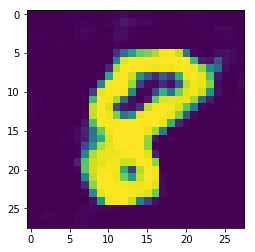

In [4]:
experiment(N_EPOCH = 20,
           BATCH_SIZE = 128,
           G_SIZE = 100,
           DIGIT = 8)